# Experimental results for active learning sampling strategies

In [1]:
%load_ext blackcellmagic

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle

2023-09-27 23:08:23.298007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%matplotlib inline

In [4]:
import os
import certifi

# Set the REQUESTS_CA_BUNDLE environment variable
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Check the path to the CA certificates bundle
print("CA Certificates Path:", os.environ["REQUESTS_CA_BUNDLE"])

CA Certificates Path: /Users/niek/niek-env/lib/python3.11/site-packages/certifi/cacert.pem


In [5]:
!export REQUESTS_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt

In [6]:
LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {
    "rcv1": "rcv1_train.binary.bz2",
    "mushrooms": "mushrooms",
    "a1a": "a1a",
    "a2a": "a2a",
    "ijcnn": "ijcnn1.tr.bz2",
    "w8a": "w8a",
}


def load_mnist(data_dir):
    dataset = MNIST(
        data_dir, train=True, transform=None, target_transform=None, download=True
    )

    X, y = dataset.data.numpy(), dataset.targets.numpy()
    X = X / 255.0
    X = X.reshape((X.shape[0], -1))
    return X, y


def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)

        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context

        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return X, y

In [7]:
from torch.utils.data import Dataset

def get_dataset(dataset_name, split, datadir, exp_dict):
    train_flag = True if split == 'train' else False
    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1

        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)

    if dataset_name == 'tiny_imagenet':
        if train_flag:
            transform_train = transforms.Compose([
                # transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                # transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagenette2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagewoof2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == "mnist":
        view = torchvision.transforms.Lambda(lambda x: x.view(-1).view(784))
        dataset = torchvision.datasets.MNIST(datadir, train=train_flag,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,)),
                                   view
                               ])
                               )

    if dataset_name == "cifar10":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR10(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name == "cifar100":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR100(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1
        # squared_max, squared_min = compute_max_eta_squared_loss(A)
        # logistic_max, logistic_min = compute_max_eta_logistic_loss(A)
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)


    if dataset_name in ["mushrooms", "w8a",
                        "rcv1", "ijcnn", 'a1a','a2a',
                        "mushrooms_convex", "w8a_convex",
                        "rcv1_convex", "ijcnn_convex", 'a1a_convex'
                        , 'a2a_convex']:

        sigma_dict = {"mushrooms": 0.5,
                      "w8a":20.0,
                      "rcv1":0.25 ,
                      "ijcnn":0.05}

        X, y = load_libsvm(dataset_name.replace('_convex', ''),
                           data_dir=datadir)

        labels = np.unique(y)

        y[y==labels[0]] = 0
        y[y==labels[1]] = 1
        # splits used in experiments
        splits = train_test_split(X, y, test_size=0.2, shuffle=True,
                    random_state=9513451)
        X_train, X_test, Y_train, Y_test = splits

        if "_convex" in dataset_name:
            if train_flag:
                # training set
                X_train = torch.FloatTensor(X_train.toarray())
                Y_train = torch.FloatTensor(Y_train)
                dataset = torch.utils.data.TensorDataset(X_train, Y_train)
            else:
                # test set
                X_test = torch.FloatTensor(X_test.toarray())
                Y_test = torch.FloatTensor(Y_test)
                dataset = torch.utils.data.TensorDataset(X_test, Y_test)

            return DatasetWrapper(dataset, split=split)

        if train_flag:
            # fname_rbf = "%s/rbf_%s_%s_train.pkl" % (datadir, dataset_name, sigma_dict[dataset_name])
            fname_rbf = "%s/rbf_%s_%s_train.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_train_X = np.load(fname_rbf)
            else:
                k_train_X = rbf_kernel(X_train, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_train_X)
                print('%s saved' % fname_rbf)

            X_train = k_train_X
            X_train = torch.FloatTensor(X_train)
            Y_train = torch.LongTensor(Y_train)

            dataset = torch.utils.data.TensorDataset(X_train, Y_train)

        else:
            fname_rbf = "%s/rbf_%s_%s_test.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_test_X = np.load(fname_rbf)
            else:
                k_test_X = rbf_kernel(X_test, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_test_X)
                print('%s saved' % fname_rbf)

            X_test = k_test_X
            X_test = torch.FloatTensor(X_test)
            Y_test = torch.LongTensor(Y_test)

            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "synthetic":
        margin = exp_dict["margin"]

        X, y, _, _ = make_binary_linear(n=exp_dict["n_samples"],
                                        d=exp_dict["d"],
                                        margin=margin,
                                        y01=True,
                                        bias=True,
                                        separable=exp_dict.get("separable", True),
                                        seed=42)
        # No shuffling to keep the support vectors inside the training set
        splits = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        X_train, X_test, Y_train, Y_test = splits

        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)

        Y_train = torch.LongTensor(Y_train)
        Y_test = torch.LongTensor(Y_test)

        if train_flag:
            dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        else:
            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "matrix_fac":
        fname = datadir + 'matrix_fac.pkl'
        if not os.path.exists(fname):
            data = generate_synthetic_matrix_factorization_data()
            ut.save_pkl(fname, data)

        A, y = ut.load_pkl(fname)

        X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.2, random_state=9513451)

        training_set = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
        test_set = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))

        if train_flag:
            dataset = training_set
        else:
            dataset = test_set

    return DatasetWrapper(dataset, split=split)

class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}

class NlpDatasetWrapper(Dataset):
    def __init__(self, corpus, data, bptt):
        self.corpus = corpus
        self.data = data
        self.bptt = bptt

    def __len__(self):
        return self.data.size(0) // self.bptt

    def __getitem__(self, index):
        data, targets = nlp_utils.get_batch(self.data, index*self.bptt, self.bptt)

        return {"images":data,
                'labels':targets,
                'meta':{'indices':index}}

def rbf_kernel(A, B, sigma):
    # func = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=True)
    # result = func(torch.from_numpy(A.toarray())[None], torch.from_numpy(B.toarray())[None])

    # np.square(metrics.pairwise.pairwise_distances(A.toarray(), B.toarray(), metric="euclidean"))


    # numpy version
    distsq = np.square(metrics.pairwise.pairwise_distances(A, B, metric="euclidean"))
    K = np.exp(-1 * distsq/(2*sigma**2))
    return K

In [8]:
import os
import urllib
import torch

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = get_dataset("mushrooms", split="train", datadir="~", exp_dict={})
y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
X = np.array([data[i]["images"].numpy() for i in range(len(data))])

data = get_dataset("mushrooms", split="test", datadir="~", exp_dict={})
ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

In [9]:
X.shape

(6499, 6499)

In [10]:
y.shape

(6499,)

In [164]:
with open('mushroom_train.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="train", datadir="~", exp_dict={}),
        f
    )

In [165]:
with open('mushroom_test.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="test", datadir="~", exp_dict={}),
        f
    )

# Specify learning algorithms

In [11]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def forward_squared_hinge(X, theta):
    fwd = np.matmul(X, theta)
    return fwd


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def grad_squared_hinge(x, y, theta):
    sy = 2 * y - 1
    grad = -np.max(1 - sy * np.dot(x, theta), 0) * sy * x
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def squared_hinge_loss(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    u = p * sy.T
    l = (1 / 2) * np.sum(np.maximum(1 - u, 0) ** 2)
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def accuracy_sign(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def sampling(x, a=1):
    return 1


sampling_exp = 0.1


def exp_sampling(x):
    sp = 0
    if x < 1:
        sp = 1 - math.exp(sampling_exp * (x - 1))
    return sp


mu = 1


def uncertainty_sampling(x):
    sp = min(1 / (1 + mu * abs(x)), 1)
    return sp


beta = 1


def squared_hinge_loss_sampling(x):
    x = x[0]
    sp = 0
    if x < 1:
        sp = (beta / 2) * (1 - (cmargin - 1) / (cmargin - x))
    return sp


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    #  if np.linalg.norm(theta) > 1:
    #    theta = theta / np.linalg.norm(theta)
    return newtheta

In [12]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

# CHANGE 4: Moved kappa, kappa0, polyakexp, omega to argument
def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    phi = 2 * np.pi * np.random.rand()
    # theta = np.array([np.cos(phi), np.sin(phi)])
    # theta = np.array([theta_star[0], -theta_star[1]])
    # CHANGE 1: random initialisation is now of shape X.shape[1]
    theta = np.random.rand(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    slosses_test = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    saccuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    Delta = np.zeros(n_iterations)
    sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # CHANGE 2: we loop over the data set size (X.shape[0]) rather than npoints
    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        thetas[i] = theta
        if mode == "rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "opt":
            raise ValueError(
                "Can't run opt-mode because on real datasets we do not know theta_star!"
            )
            w = 10 * theta_star
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "uncertainty":
            w = theta
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "squared_hinge":
            p = np.dot(xx, theta)
            pz = sampling((2 * yy - 1) * p)
            grad = grad_squared_hinge(xx, yy, theta)
        elif mode == "polyak":
            p = np.dot(xx, theta)
            grad = grad_squared_hinge(xx, yy, theta)
            #        zeta = min(kappa * loss(p, yy) / (np.linalg.norm(grad)**2), kappa0)
            zeta = min(
                kappa * 1 / (2 * np.linalg.norm(xx) ** 2), kappa0
            )  # squared hinge loss function
            if (2 * yy - 1) * p > 1:
                zeta = 0
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-becpi":  # binary cross entropy pi sampling
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            grad = zeta * grad / pz
        elif mode == "polyak-bec-absloss":  # binary cross entropy
            # Hyperparameter tune for different values of polyakexp (including 0), compare to random
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            gradient = backward(xx, yy, p)
            theta = update(theta, zeta * gradient)
        elif mode == "bec-absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.min([1, np.max([0, prob_const * pz])])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1_default_alpha_x0":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([bec, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-bec-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy) + lam * np.linalg.norm(theta)

        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest) + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 100 == 0:
            print("loss:", losses_test[i], "theta:", theta)

    # CHANGE 3: We write all results to a dict for easier access
    return {
        "losses": losses.tolist(),
        "losses_test": losses_test.tolist(),
        "slosses_test": slosses_test.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        "saccuracies_test": saccuracies_test.tolist(),
        #"samples": samples.tolist(),
        "thetas": thetas.tolist(),
    }

# Evaluation



## Run hyperparameter search
Since we do not want to touch the test set that we will use to create our plots (to avoid overfitting on the test set), we split the train set into a train and val set.

In [13]:
trials = {}
best_knowns = {}

In [20]:
from sklearn.model_selection import KFold

In [22]:
# Given data
kappa = 2.184
kappa0 = 0.395
pz_values = {
    #0.0: 1,
    0.1: 0.9114,
    0.2: 0.8306,
    0.3: 0.7571,
    0.4: 0.6900,
    0.5: 0.6288,
    0.6: 0.5731,
    0.7: 0.5224,
    0.8: 0.4761,
    0.9: 0.4339
}

# Calculate c for each polyakexp value
c_values = {}
for polyakexp, pz in pz_values.items():
    zeta = (pz ** (1 / polyakexp))  # Calculate zeta using inverse operation
    zeta = min(zeta, kappa0)
    c = zeta / kappa
    c_values[polyakexp] = c

# Print the calculated c values for each polyakexp
for polyakexp, c in c_values.items():
    print(f"polyakexp: {polyakexp}, c: {c}")

polyakexp: 0.1, c: 0.18086080586080586
polyakexp: 0.2, c: 0.18086080586080586
polyakexp: 0.3, c: 0.18086080586080586
polyakexp: 0.4, c: 0.18086080586080586
polyakexp: 0.5, c: 0.18086080586080586
polyakexp: 0.6, c: 0.18086080586080586
polyakexp: 0.7, c: 0.18086080586080586
polyakexp: 0.8, c: 0.18086080586080586
polyakexp: 0.9, c: 0.18086080586080586


In [23]:
# New given data
kappa_new = 1.5
kappa0_new = 0.078
pz_values_new = {
    #0.0: 1,
    0.1: 0.774,
    0.2: 0.600,
    0.3: 0.465,
    0.4: 0.359,
    0.5: 0.278,
    0.6: 0.216,
    0.7: 0.167,
    0.8: 0.129,
    0.9: 0.100
}

# Calculate c for each polyakexp value using the new data
c_values_new = {}
for polyakexp, pz in pz_values_new.items():
    zeta_new = (pz ** (1 / polyakexp))  # Calculate zeta using inverse operation
    zeta_new = min(zeta_new, kappa0_new)
    c_new = zeta_new / kappa_new
    c_values_new[polyakexp] = c_new

# Print the calculated c values for each polyakexp using the new data
for polyakexp, c in c_values_new.items():
    print(f"polyakexp: {polyakexp}, c (new): {c}")

polyakexp: 0.1, c (new): 0.05144205954556377
polyakexp: 0.2, c (new): 0.05183999999999999
polyakexp: 0.3, c (new): 0.051930031246384366
polyakexp: 0.4, c (new): 0.05148074965265711
polyakexp: 0.5, c (new): 0.05152266666666668
polyakexp: 0.6, c (new): 0.05184
polyakexp: 0.7, c (new): 0.05170156623728572
polyakexp: 0.8, c (new): 0.05154017381245793
polyakexp: 0.9, c (new): 0.05161757884540847


In [27]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import csv
import functools

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_file = os.path.join(notebook_dir, "hyperparam_results_run_optimised_constant_pz_weighted_mean_loss_cv.csv")

search_spaces = {
    #"uncertainty": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"squared_hinge": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"polyak": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},
    "bec-absloss": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
    },
    "rand": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        # pz0=0.5 yields E[pz] = 0.5
        'pz0': 0.5
    },
    "polyak-bec-absloss": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 1, 2),
        'kappa0': hp.loguniform('kappa0', -3, -0.1),
        # Derived by hand analytically that 0.272 yields E[pz] = 0.5
        'polyakexp': 0.272
    },
    #"polyak-becpi": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},
    "polyak-rand": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
        # Under bec-absloss, E[pz] = 0.5
        # Under polyak-bec-absloss, E[pz] = 0.5 for polyakexp 0.272
        # Under rand with pz0=0.5, E[pz] = 0.5
        # Hence, under polyak-rand with pz=0.5, E[pz] = 0.5 should also be 0.272 under pz0=0.5 
        'pz0': 0.5,
        'polyakexp': 0.272
    },
} 

# Create a Trials object to store optimization results
def create_trial(row):
    # Extract hyperparameter values
    hyperparameters = {param: row[param] for param in param_columns}
    
    # Define the trial dictionary
    trial = {
        'result': {
            'loss': row[loss_column],
            'status': STATUS_OK,
        },
        'misc': {
            'vals': hyperparameters,
            'idxs': {param: [0] for param in param_columns},
        },
    }
    
    return trial

for method in search_spaces:
    if method not in trials:
        trials[method] = Trials()
    if method not in best_knowns:
        best_loss = float('inf')
        best_knowns[method] = {
            "best_loss": best_loss,
            "best_params": None
        }
    """
    existing_runs = hyperparam_results[hyperparam_results.algorithm == method].reset_index()
    print(f"Prepopulating {method}")
    
    for idx, row in existing_runs.iterrows():
        # Extract hyperparameters from the dictionary column
        hyperparameters = eval(row.hyperparams)

        # Define the trial dictionary
        trial = {
            'tid': idx, 
            'state': STATUS_OK,
            'result': {
                'loss': row.loss,
                'status': STATUS_OK,
            },
            'misc': {
                'vals': hyperparameters,
                'idxs': {param: [0] for param in hyperparameters.keys()},
                'cmd': None,
                'tid': idx,
            },
            'spec': None,
            'owner': None,
            'book_time': None,
            'refresh_time': None,
            'exp_key': None,
        }

        print(f"Adding trial {trial}")
        # Add the trial to the Trials object
        trials[method].insert_trial_doc(trial)
        if row.loss < best_loss:
            best_loss = row.loss
        """

# Define the original function with all arguments
def train_and_get_last_loss(X, y, mode, params, num_folds = 3):
    kf = KFold(n_splits=num_folds)
    
    total_loss = 0
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        d = train_model(X_train, y_train, X_val, y_val, mode=mode, verbose=False, **params)

        w = [(i+1) / len(d["losses_test"]) for i in range(len(d["losses_test"]))]
        w_array = np.array(w)
        losses_test_array = np.array(d["losses_test"])
        current_loss = np.mean(w_array * losses_test_array)
        
        total_loss += current_loss

    mean_loss = total_loss / num_folds
    if mean_loss < best_knowns[method]["best_loss"]:
        best_knowns[method]["best_loss"] = mean_loss
        best_knowns[method]["best_params"] = params
        print(f"New best parameters: {best_knowns[method]['best_params']} with loss {mean_loss}")

    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file, delimiter='\t')

        if not os.path.exists(csv_file):
            writer.writerow(['Method', 'Best Loss', 'Best Params'])  # Write header if file doesn't exist

        writer.writerow([method, mean_loss, params])

    return mean_loss

# Fix some arguments using functools.partial

for method in search_spaces:
    print(f"Tuning for {method}")
    get_loss_after_training = functools.partial(
        train_and_get_last_loss,
        X, y, method
    )

    # Perform hyperparameter optimization using Hyperopt
    best = fmin(
        fn=get_loss_after_training,
        space=search_spaces[method],
        algo=tpe.suggest,
        max_evals=40,
        trials=trials[method],
    )
    print(f"Finished tuning for {method}")
    print()


Tuning for bec-absloss
New best parameters: {'eta': 0.04033891323805293, 'lam': 1.563443161659595} with loss 0.4255454126465776                                                    
New best parameters: {'eta': 0.12440389010218025, 'lam': 0.3739058384684292} with loss 0.40703912248277857                                                  
New best parameters: {'eta': 0.08059920922301554, 'lam': 0.40806197240523323} with loss 0.40658057617827953                                                 
New best parameters: {'eta': 0.24493500671859983, 'lam': 0.028871905688086008} with loss 0.3839544356493303                                                 
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [4:36:09<00:00, 414.24s/trial, best loss: 0.3840100609829988]
Finished tuning for bec-absloss

Tuning for rand
New best parameters: {'eta': 0.02257465107763674, 'lam': 1.0816573290602962, 'pz0': 0.5} with loss 0.45548677144742394                         

## Use best hyperparams to construct plot
Now that we found the best hyperparameters, we compare the test set performance of each learning algorithm when training on the full train set (train + val).

In [13]:
hyperparam_results = pd.read_csv("hyperparam_results_run_optimised_constant_pz_weighted_mean_loss_cv.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [14]:
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()

In [15]:
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

In [16]:
import ast

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [17]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.24493500671859983, 'lam': 0.028871905688086008},
 'polyak-bec-absloss': {'eta': 0.0870024877029075,
  'kappa': 1.656031766669495,
  'kappa0': 0.0505333666032807,
  'lam': 1.6218983887925547,
  'polyakexp': 0.272},
 'polyak-rand': {'eta': 0.08112685368817803,
  'kappa': 1.6152892683097693,
  'kappa0': 0.17891783551035084,
  'lam': 0.006187345020009848,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.1641037592632436, 'lam': 0.05287300300540476, 'pz0': 0.5}}

In [18]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.24493500671859983, 'lam': 0.028871905688086008},
 'polyak-bec-absloss': {'eta': 0.0870024877029075,
  'kappa': 1.656031766669495,
  'kappa0': 0.0505333666032807,
  'lam': 1.6218983887925547,
  'polyakexp': 0.272},
 'polyak-rand': {'eta': 0.08112685368817803,
  'kappa': 1.6152892683097693,
  'kappa0': 0.17891783551035084,
  'lam': 0.006187345020009848,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.1641037592632436, 'lam': 0.05287300300540476, 'pz0': 0.5}}

In [19]:
polyak_exps = list(range(10))
polyak_strs = [f"0.{elem}" for elem in polyak_exps]
polyak_exps = [eval(elem) for elem in polyak_strs]
polyak_exps

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

## Bec-absloss with Polyak

In [20]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
polyak_bec_params = hyperparam_per_algo["polyak-bec-absloss"]

polyak_becs2 = {
    f"polyak_bec_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-bec-absloss", verbose=True, **(polyak_bec_params | {"polyakexp": polyak_exp})
    )
    for polyak_str, polyak_exp in zip(polyak_strs, polyak_exps)
}

Training with algorithm polyak-bec-absloss: 6499 iterations with d=6499
loss: 70.91091967063733 theta: [0.14840253 0.23197075 0.88651104 ... 0.72422467 0.13576636 0.15189519]
loss: 0.740789756986548 theta: [9.85949094e-05 1.52068045e-04 5.86536828e-04 ... 4.81131133e-04
 9.01935813e-05 1.00728386e-04]


KeyboardInterrupt: 

In [35]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyakbec_results_file, "wb") as f:
    pickle.dump(polyak_becs2, f)

In [18]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyakbec_results_file, "rb") as f:
    polyak_becs2 = pickle.load(f)

In [26]:
for k in polyak_becs2.keys():
    del polyak_becs2[k]["thetas"]

## Random baseline

In [54]:
# Set the random parameter p in Bernoulli(p) equal to the average
# pz values of bec-absloss with Polyak (under different polyakexp).
# For comparable results.

d_probs = [
    1.0, 
    0.7745240529580663, 
    0.5998875086105894, 
    0.46462730448799056, 
    0.3598650229870199, 
    0.27872411612175435, 
    0.21587853207577587, 
    0.16720311560996784, 
    0.12950283476944838, 
    0.10030306045519194
]

In [ ]:
rand_params = hyperparam_per_algo["rand"]

rand_results = {
    f"rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="rand", verbose=True, **(rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

In [38]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(rand_results_file, "wb") as f:
    pickle.dump(rand_results, f)

In [27]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(rand_results_file, "rb") as f:
    rand_results = pickle.load(f)
    
for k in rand_results.keys():
    del rand_results[k]["thetas"]

## Random baseline with Polyak

In [ ]:
polyak_rand_params = hyperparam_per_algo["polyak-rand"]

polyak_rand_results = {
    f"polyak_rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-rand", verbose=True, **(polyak_rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

In [40]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyak_rand_results_file, "wb") as f:
    pickle.dump(polyak_rand_results, f)

In [28]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyak_rand_results_file, "rb") as f:
    polyak_rand_results = pickle.load(f)
    
for k in polyak_rand_results.keys():
    del polyak_rand_results[k]["thetas"]

## Bec-absloss, without Polyak

In [ ]:
# We again need comparable pz values to each of the run for
# bec-absloss with Polyak (under different polyakexp).

# To achieve this we 
#  1. Do one run with bec-absloss and determine the mean pz
#  2. For each of the bec-absloss with Polyak runs, we calculate the ratio with bec-absloss pz
#  3. We run "scaled-bec-absloss", as a bec-absloss with a multiplicative constant scaling factor on pz
results_bec_absloss = train_model(
    X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **hyperparam_per_algo["bec-absloss"]
)

In [42]:
prob_multiplier = [d_prob / np.mean(results_bec_absloss["probs"]) for d_prob in d_probs]

In [43]:
prob_multiplier

[2.0037801004479796,
 1.5519758846356901,
 1.2020426522612149,
 0.9310109468578197,
 0.7210903719086452,
 0.5585018373997233,
 0.43257310668736054,
 0.3350382757921565,
 0.2594952032626234,
 0.20098527655414428]

In [ ]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
bec_absloss_params = hyperparam_per_algo["bec-absloss"]

becs_absloss_results = {
    f"bec-absloss_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **(bec_absloss_params | {"prob_const": prob_multiplier})
    )
    for polyak_str, prob_multiplier in zip(polyak_strs, prob_multiplier)
}

In [45]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(becs_absloss_results_file, "wb") as f:
    pickle.dump(becs_absloss_results, f)

In [29]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(becs_absloss_results_file, "rb") as f:
    becs_absloss_results = pickle.load(f)
    
for k in becs_absloss_results.keys():
    del becs_absloss_results[k]["thetas"]

## Plot Polyak-bec results

In [30]:
import re
df_test_losses = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_becs2.items()]
)
df_test_losses.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses = df_test_losses.explode(["test_loss", "test_accuracy"])
df_test_losses["iteration"] = df_test_losses.groupby('polyak_exp').cumcount()+1
df_test_losses = df_test_losses.reset_index()

In [31]:
df_test_losses["cost"] = [np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses.iteration, df_test_losses.labeled)]

In [32]:
import seaborn as sns

(0.0, 6823.95)

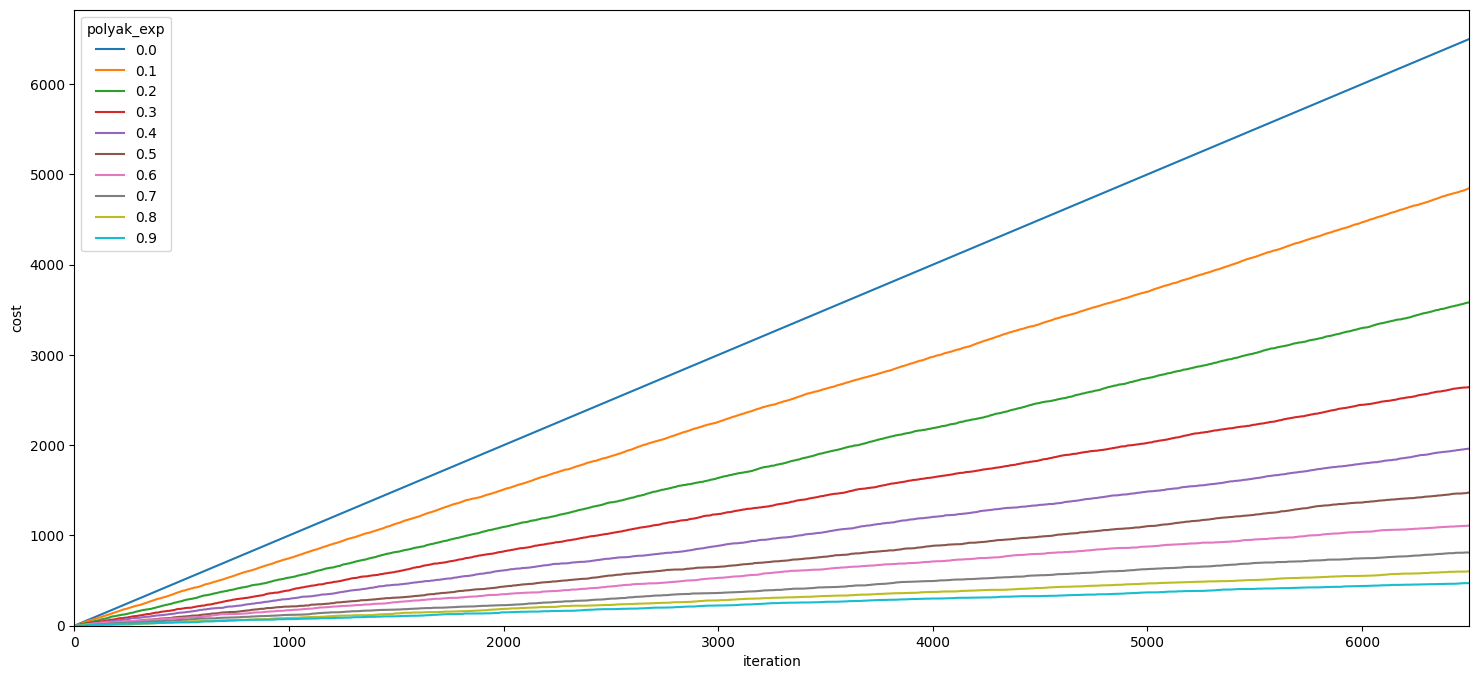

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="cost", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

(0.0, 80.46563269779297)

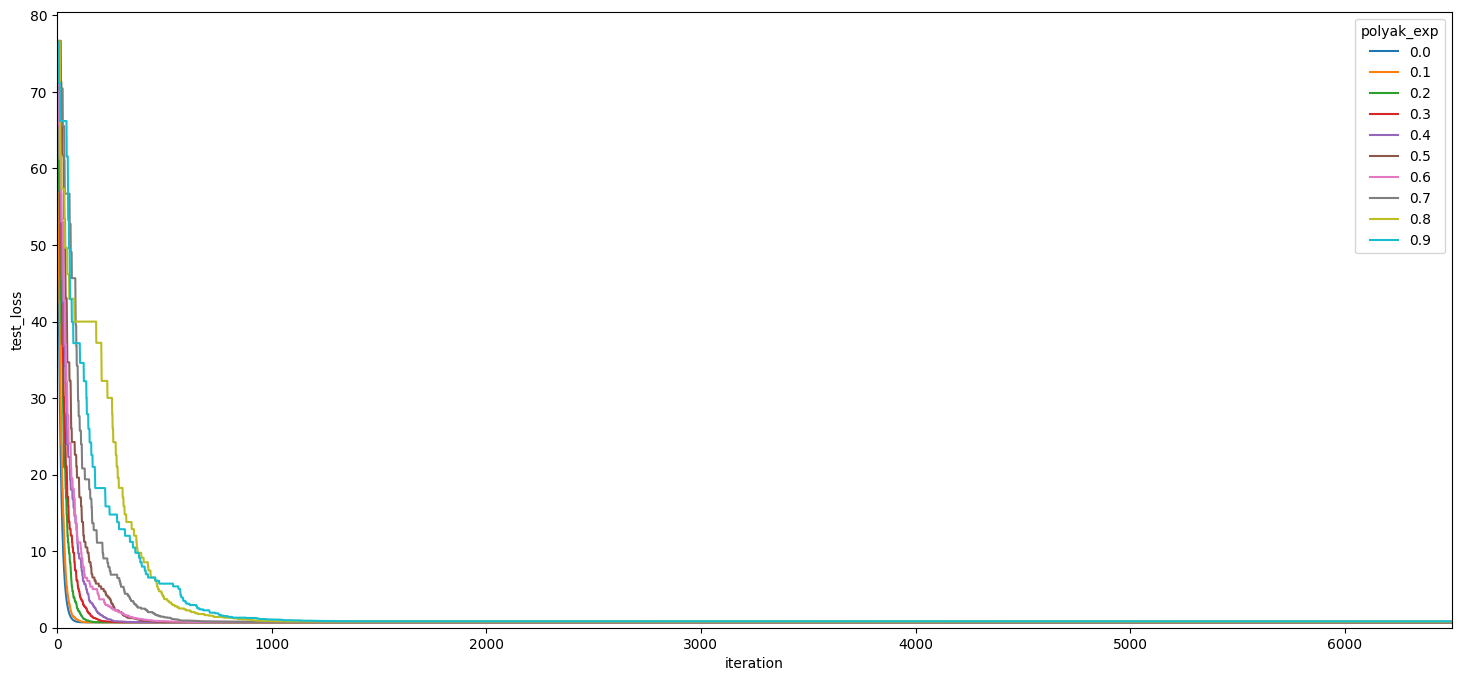

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_accuracy", hue="polyak_exp")

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_accuracy", hue="polyak_exp")
ax.set_xlim((0, 4000))

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 1000))
ax.set_ylim(bottom=0)

## Make comparison plots

In [33]:
df_test_losses["method"] = "polyak_absloss"

import re
df_test_losses_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in rand_results.items()]
)


df_test_losses_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_rand = df_test_losses_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_rand["iteration"] = df_test_losses_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_rand = df_test_losses_rand.reset_index()
df_test_losses_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_rand.iteration, df_test_losses_rand.labeled)
]
df_test_losses_rand["method"] = "rand"


import re
df_test_losses_bec_absloss = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in becs_absloss_results.items()]
)


df_test_losses_bec_absloss.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_bec_absloss = df_test_losses_bec_absloss.explode(["test_loss", "test_accuracy"])
df_test_losses_bec_absloss["iteration"] = df_test_losses_bec_absloss.groupby('polyak_exp').cumcount()+1
df_test_losses_bec_absloss = df_test_losses_bec_absloss.reset_index()
df_test_losses_bec_absloss["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_bec_absloss.iteration, df_test_losses_bec_absloss.labeled)
]
df_test_losses_bec_absloss["method"] = "absloss"


import re
df_test_losses_polyak_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_rand_results.items()]
)
df_test_losses_polyak_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_polyak_rand = df_test_losses_polyak_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_polyak_rand["iteration"] = df_test_losses_polyak_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_polyak_rand = df_test_losses_polyak_rand.reset_index()
df_test_losses_polyak_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_polyak_rand.iteration, df_test_losses_polyak_rand.labeled)
]
df_test_losses_polyak_rand["method"] = "polyak_rand"

In [ ]:
df_test_losses_rand

In [ ]:
df_test_losses

In [ ]:
df_test_losses_polyak_rand

In [ ]:
df_test_losses_bec_absloss[df_test_losses_bec_absloss.iteration == 6499]

In [34]:
df_test_losses = pd.concat([df_test_losses_rand, df_test_losses_bec_absloss, df_test_losses, df_test_losses_polyak_rand])

In [35]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

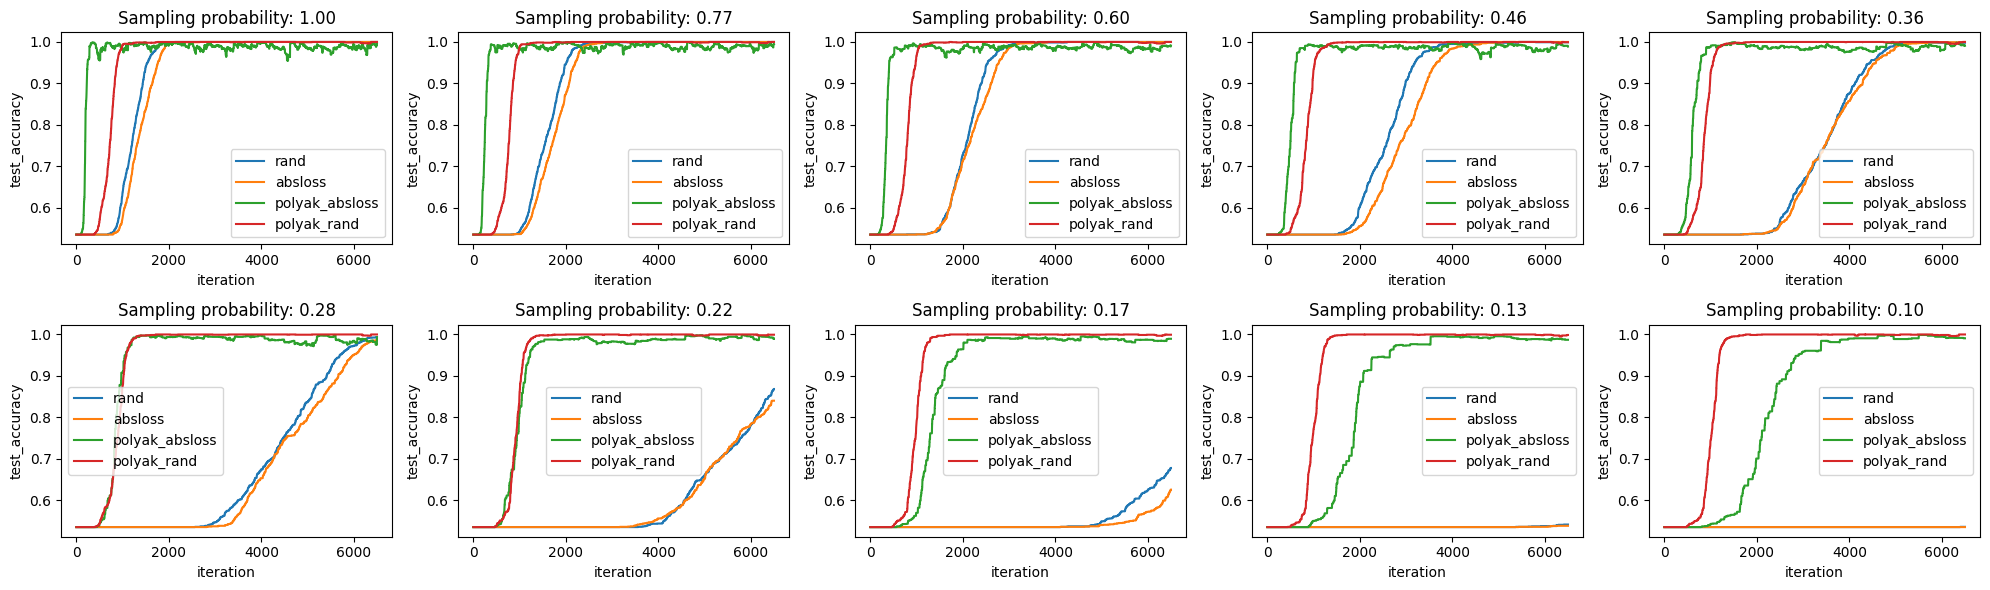

In [57]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"Sampling probability: {d_probs[i]:.2f}")
    ax.legend()
f.tight_layout()

In [ ]:
## Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)
##      - mean train loss (sloss) curve
##      - mean test loss curve
##      - accuracy
## Plot 1: random vs polyak_exponent, show that Polyak_exponent is still more efficient even when we sample, under different alpha's
##      - train loss curve
##      - test loss curve
##      - accuracy
## Plot 2: polyak_absloss vs absloss, show that Polyak also works in an absolute loss setting ()
## Plot 3: Dima's sensitivity plots. How sensitive are we to injected noise

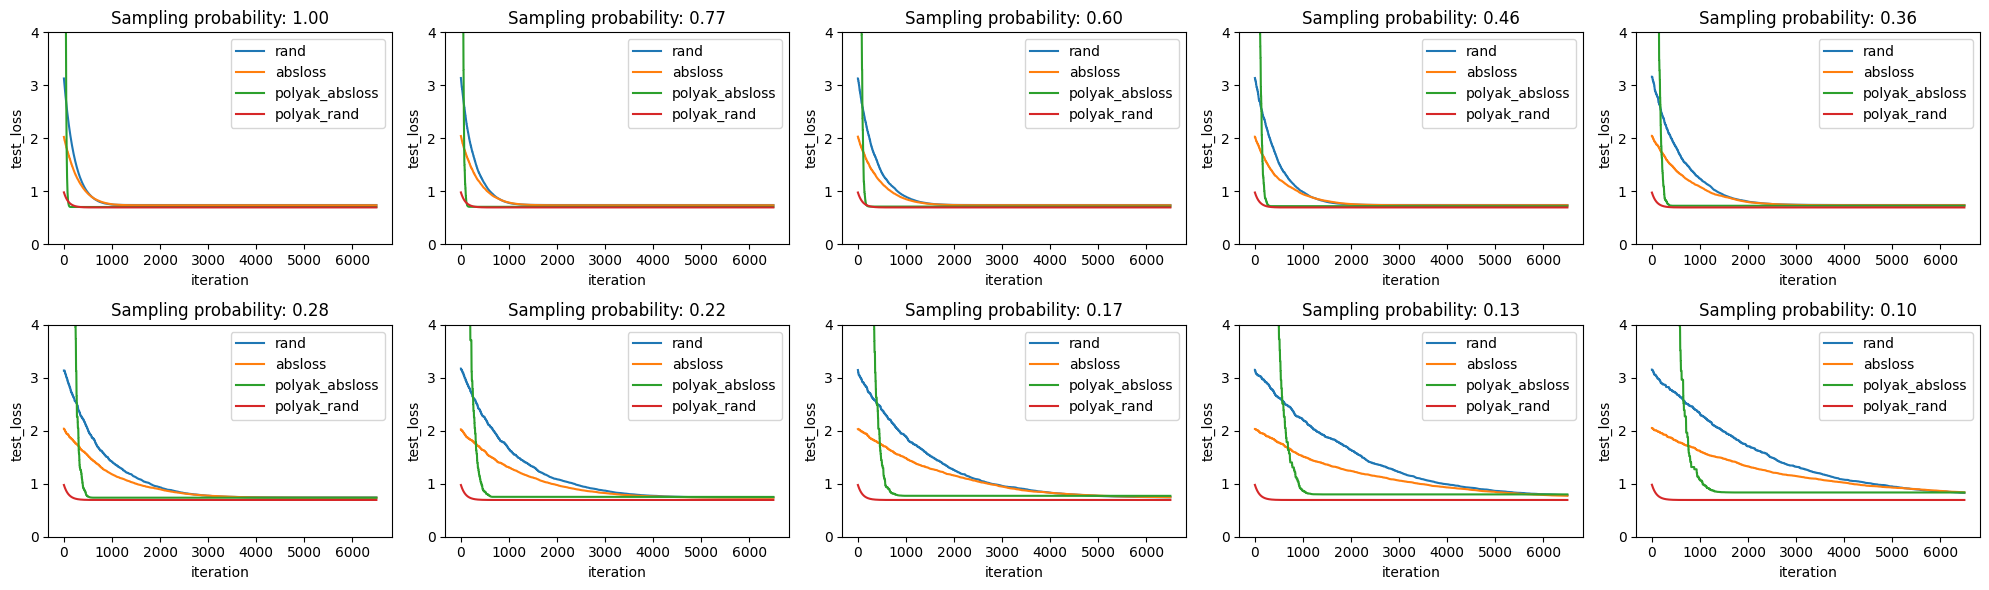

In [56]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"Sampling probability: {d_probs[i]:.2f}")
    ax.set_ylim((0, 4))
    ax.legend()
f.tight_layout()

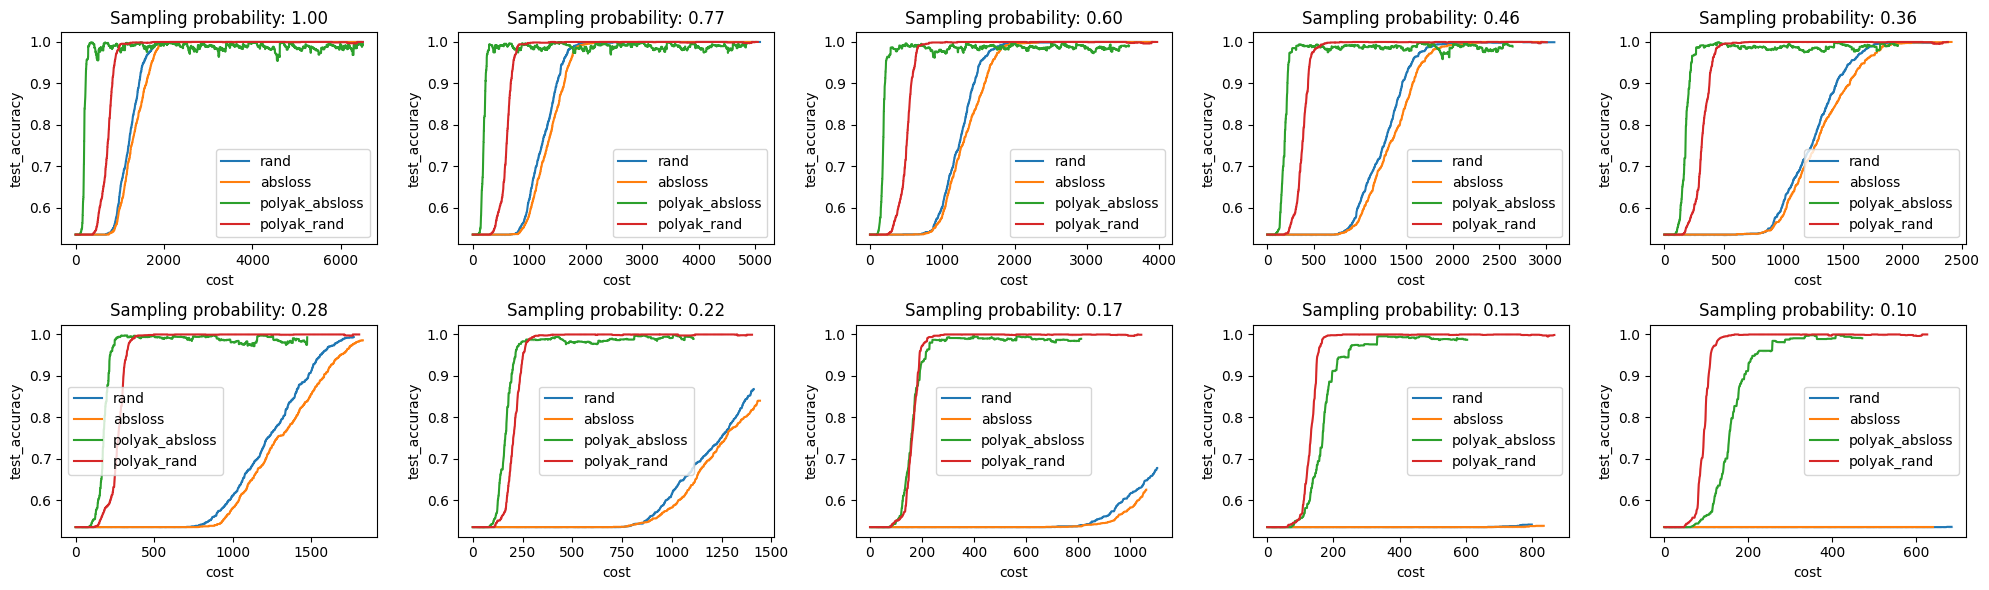

In [58]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"Sampling probability: {d_probs[i]:.2f}")
    ax.legend()
f.tight_layout()

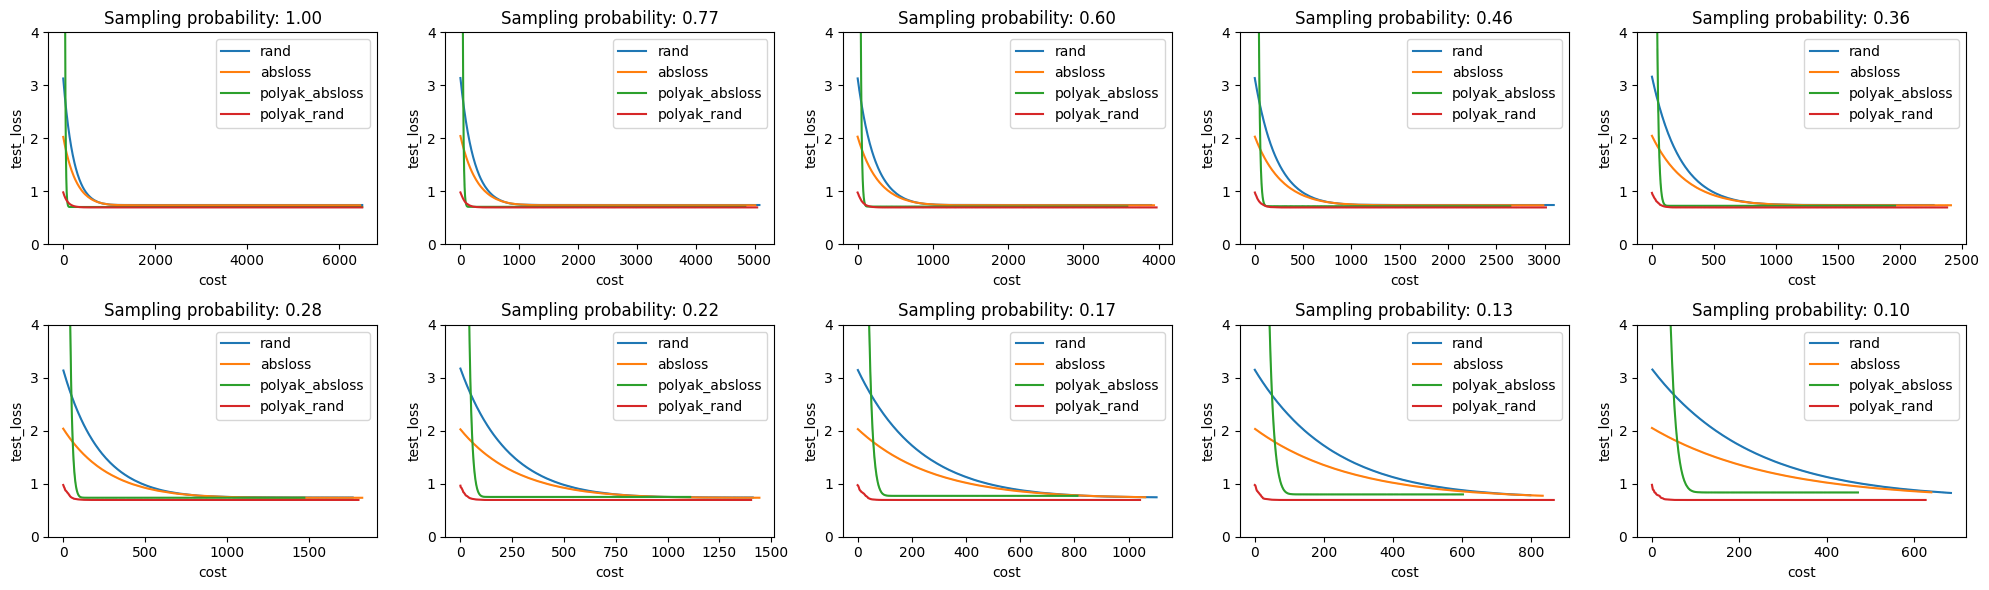

In [59]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_ylim((0, 4))
    ax.set_title(f"Sampling probability: {d_probs[i]:.2f}")
    ax.legend()
f.tight_layout()

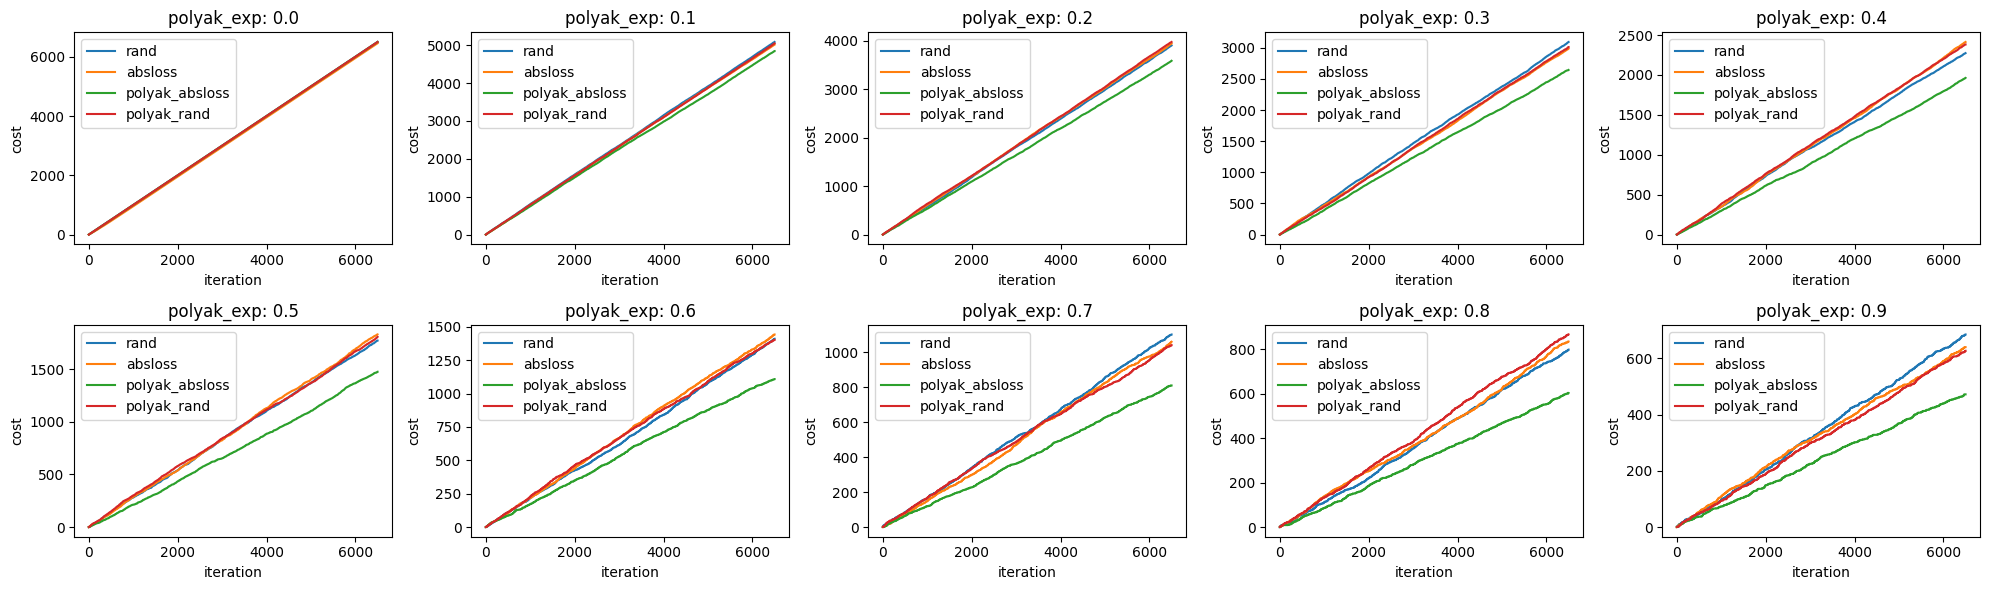

In [42]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="cost", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

In [48]:
for r in rand_results.keys():
    print(f"{r}: {np.mean(rand_results[r]['probs'])}")


rand_0.0: 1.0
rand_0.1: 0.7745240529580661
rand_0.2: 0.5998875086105891
rand_0.3: 0.46462730448799056
rand_0.4: 0.35986502298701983
rand_0.5: 0.27872411612175435
rand_0.6: 0.2158785320757759
rand_0.7: 0.16720311560996784
rand_0.8: 0.1295028347694484
rand_0.9: 0.10030306045519197


In [49]:
for r in polyak_becs2.keys():
    print(f"{r}: {np.mean(polyak_becs2[r]['probs'])}")


polyak_bec_0.0: 1.0
polyak_bec_0.1: 0.7419212721953483
polyak_bec_0.2: 0.5504471741359643
polyak_bec_0.3: 0.408388467711289
polyak_bec_0.4: 0.3029920915142684
polyak_bec_0.5: 0.22479627800139557
polyak_bec_0.6: 0.1667811405595745
polyak_bec_0.7: 0.12373847598215079
polyak_bec_0.8: 0.09180420752019085
polyak_bec_0.9: 0.06811149443626574


In [50]:
for r in polyak_rand_results.keys():
    print(f"{r}: {np.mean(polyak_rand_results[r]['probs'])}")

polyak_rand_0.0: 1.0
polyak_rand_0.1: 0.7745240529580661
polyak_rand_0.2: 0.5998875086105891
polyak_rand_0.3: 0.46462730448799056
polyak_rand_0.4: 0.35986502298701983
polyak_rand_0.5: 0.27872411612175435
polyak_rand_0.6: 0.2158785320757759
polyak_rand_0.7: 0.16720311560996784
polyak_rand_0.8: 0.1295028347694484
polyak_rand_0.9: 0.10030306045519197


In [52]:
for r in becs_absloss_results.keys():
    print(f"{r}: {np.mean(becs_absloss_results[r]['probs'])}")


bec-absloss_0.0: 0.9927062163792975
bec-absloss_0.1: 0.7748089287665765
bec-absloss_0.2: 0.6001138454239615
bec-absloss_0.3: 0.46480860781038985
bec-absloss_0.4: 0.35965045429675674
bec-absloss_0.5: 0.278694930109958
bec-absloss_0.6: 0.21557566129648265
bec-absloss_0.7: 0.166865114612842
bec-absloss_0.8: 0.1294103533801973
bec-absloss_0.9: 0.10002878191273452


In [67]:
for r in becs_absloss_results.keys():
    print(f"{r}: {np.min(becs_absloss_results[r]['losses_test'])}")

bec-absloss_0.0: 0.7352944590917666
bec-absloss_0.1: 0.7352952053821736
bec-absloss_0.2: 0.7352816140262175
bec-absloss_0.3: 0.735342164479104
bec-absloss_0.4: 0.735356651443028
bec-absloss_0.5: 0.7354024049540823
bec-absloss_0.6: 0.7360695669096317
bec-absloss_0.7: 0.7452454935199615
bec-absloss_0.8: 0.7736995529842488
bec-absloss_0.9: 0.838073301447371


In [65]:
becs_absloss_results[r].keys()

dict_keys(['losses', 'losses_test', 'slosses_test', 'labeled', 'theta', 'probs', 'accuracies', 'accuracies_test', 'saccuracies_test'])